In [32]:
import cv2
import matplotlib.pyplot as plt
from fonctions_image import *

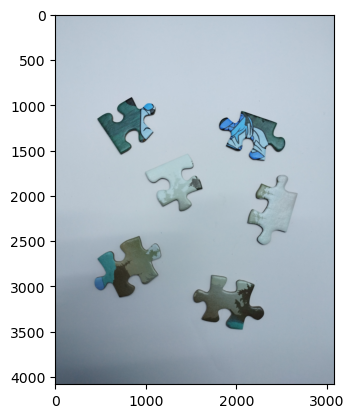

In [33]:
puzzle = cv2.imread('../nos_puzzles/yakari.jpg')
image_test = cv2.imread("pieces_dures.jpg")

plt.imshow(image_test)

Found 4 valid pieces
Piece areas: [191504, 196946, 267220, 246872]

Piece 0:
Position: (446, 898)
Size: (683, 673)
Area: 191504

Piece 1:
Position: (1788, 1051)
Size: (768, 588)
Area: 196946

Piece 2:
Position: (413, 2428)
Size: (778, 724)
Area: 267220

Piece 3:
Position: (1502, 2858)
Size: (822, 644)
Area: 246872


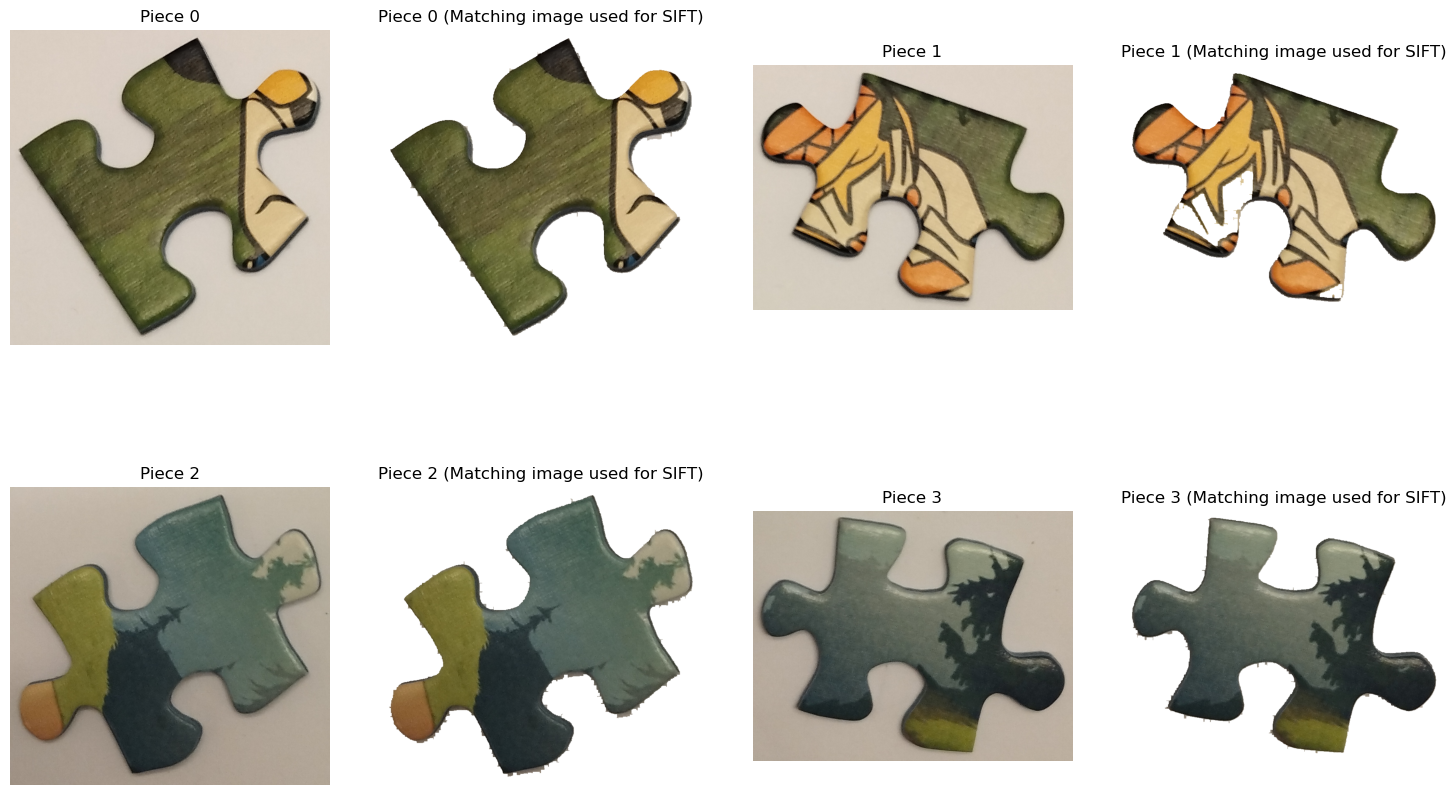

In [34]:
pieces = extract_pieces(image_test)
show_found_pieces(pieces)


### Idée : on réduit le masque pour enlever toutes les features au bord

In [35]:
def filter_keypoints_by_mask(keypoints, descriptors, mask, margin=10):
    height, width = mask.shape
    kernel = np.ones((margin*2+1, margin*2+1), np.uint8)
    eroded_mask = cv2.erode(mask.astype(np.uint8), kernel)
    
    filtered_keypoints = []
    filtered_descriptors = []
    
    for i, kp in enumerate(keypoints):
        x, y = map(int, kp.pt)
        if 0 <= y < height and 0 <= x < width and eroded_mask[y, x] > 0:
            filtered_keypoints.append(kp)
            filtered_descriptors.append(descriptors[i])
    
    return filtered_keypoints, np.array(filtered_descriptors)

### Sift

In [36]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

keypoints_full, descriptors_full = sift.detectAndCompute(puzzle, None)

In [37]:
def calculate_keypoints(piece) :
    keypoints_piece, descriptors_piece = sift.detectAndCompute(piece["matching_image"], None)
    
    keypoints_piece, descriptors_piece = filter_keypoints_by_mask(
    keypoints_piece,
    descriptors_piece,
    piece["binary_mask"]
    )
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_piece, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_piece, descriptors_piece

In [ ]:
def calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece) :
    
    matches = bf.knnMatch(descriptors_piece, descriptors_full, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:  # Lowe's ratio test
            good_matches.append(m)
            
    matched_img = cv2.drawMatches(piece['image'], keypoints_piece,
                               puzzle, keypoints_full,
                                good_matches, None,
                                matchColor=(0, 255, 0),
                                matchesThickness=3)
    
    matched_img = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)
    plt.imshow(matched_img)

    return good_matches

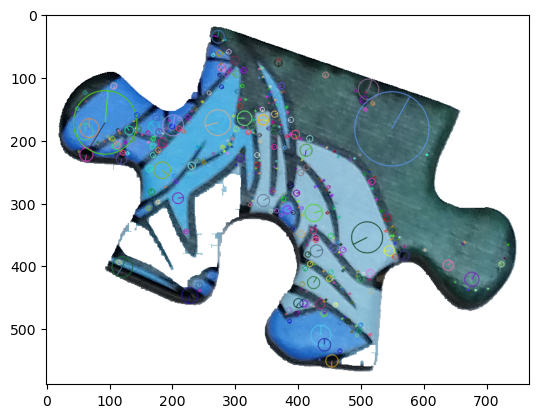

In [39]:
piece = pieces[1]
keypoints_piece, descriptors_piece = calculate_keypoints(piece)

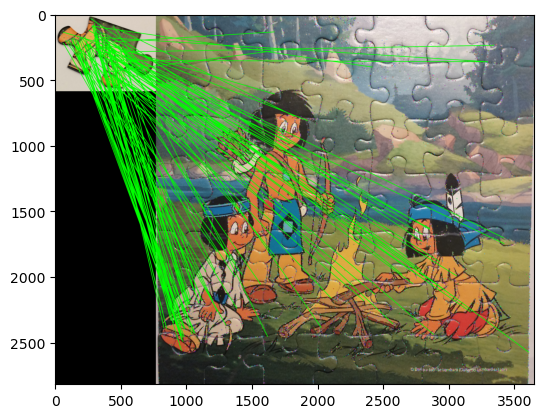

In [40]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece)

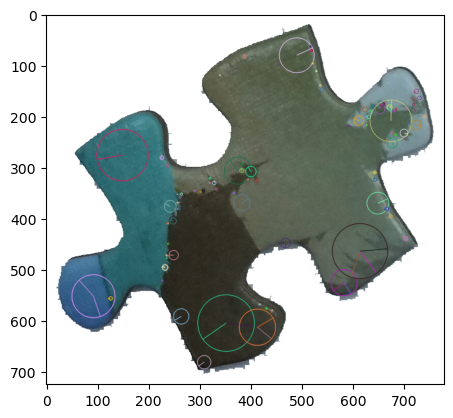

In [41]:
piece = pieces[2]
keypoints_piece, descriptors_piece = calculate_keypoints(piece)

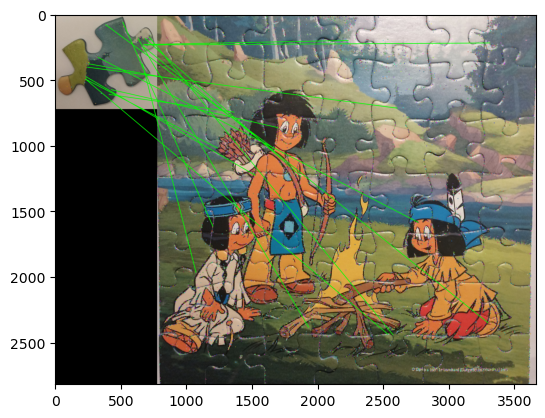

In [42]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece)

### Akaze

In [43]:
akaze = cv2.AKAZE_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

keypoints_full, descriptors_full = akaze.detectAndCompute(puzzle, None)


In [44]:
def calculate_keypoints_akaze(piece) :
    keypoints_piece, descriptors_piece = akaze.detectAndCompute(piece["matching_image"], None)
    
    keypoints_piece, descriptors_piece = filter_keypoints_by_mask(
    keypoints_piece,
    descriptors_piece,
    piece["binary_mask"]
)
    
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_piece, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_piece, descriptors_piece

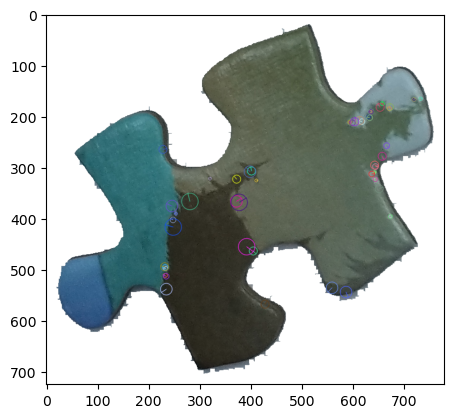

In [45]:
piece = pieces[2]
keypoints_piece, descriptors_piece = calculate_keypoints_akaze(piece)

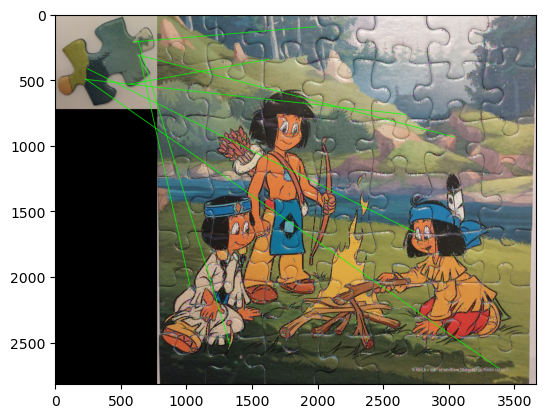

In [46]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece)